# Mental illness prediction from microbiome structure using ML

It's well known that somatic disruption of the gut and microbiome strucyture is correlated (IBD, CRC, Neoplasms).

But how about mental illness?

In [1]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import zscore
import random
from pycaret.classification import *
from scipy.stats import kruskal
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# # Download abundance data from GMrepo

# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/superkingdom2descendents.txt.gz", "superkingdom2descendents.txt.gz")
# print("taxonomy table download finished)

# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/samples_loaded.txt.gz", "samples_loaded.txt.gz")
# print("sample table download finished)

# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/sample_to_run_info.txt.gz", "sample_to_run_info.txt.gz")
# print("sample run download finished)
      
# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/species_abundance.txt.gz", "species_abundance.txt.gz")
# print("abundance table download finished)

In [3]:
#import data

abundance_raw = pd.read_table("species_abundance.txt")
taxonomy_table = pd.read_table("superkingdom2descendents.txt")
sample_table = pd.read_table("samples_loaded.txt")
run_table = pd.read_table("sample_to_run_info.txt", dtype = 'str')

In [4]:
# using only genus for this project

abundance_genus  = abundance_raw[abundance_raw['taxon_rank_level'].str.contains('genus', case=False)]

In [5]:
# reformat: rownames are samples and colnames are taxa

pivoted_df = abundance_genus.pivot_table(index='loaded_uid', columns='ncbi_taxon_id', values='relative_abundance', fill_value=0)

In [6]:
# rename colnames with actual genus names

# Replace blanks with underscores in the scientific_name column
taxonomy_table['scientific_name'] = taxonomy_table['scientific_name'].str.replace(' ', '_')

# Create a mapping between ncbi_taxon_id and scientific_name
mapping = dict(zip(taxonomy_table['ncbi_taxon_id'], taxonomy_table['scientific_name']))

# Rename columns in pivoted_df based on the mapping
pivoted_df.rename(columns=mapping, inplace=True)

In [7]:
pivoted_df #taxonomy table is incomplete... must complete later with newer ncbi tax tables

ncbi_taxon_id,-1,Azorhizobium,Cellvibrio,Dictyoglomus,Methylophilus,Pelobacter,Phenylobacterium,Shewanella,Myxococcus,Stigmatella,...,2211641,2212691,2212731,2282523,2282740,2282741,2282742,2304691,2304692,2529408
loaded_uid,,,,,,,,,,,,,,,,,,,,,
1,0.29633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.36680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.13739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3.32762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52855,9.70667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52856,1.01729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52857,3.61897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#merge metadata into a single df

metadata_df = pd.merge(run_table, sample_table, left_on='run_id', right_on='accession_id')

In [9]:
metadata_df

,checking,project_id,our_project_id,sample_name,original_sample_description,curated_sample_description,run_id,sample_id,second_sample_id,experiment_type,...,Antibiotics.Dose,Days.Without.Antibiotics.Use,uid,accession_id,data_type,tool_used,results_version,last_updated,QCStatus,QCMessage
0,1,PRJDB4360,NaN,Japanese001,Healthy Japanese gut microbiota,NaN,DRR048993,NaN,SAMD00042843,Amplicon,...,NaN,NaN,6339,DRR048993,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
1,1,PRJDB4360,NaN,Japanese002,Healthy Japanese gut microbiota,NaN,DRR048994,NaN,SAMD00042844,Amplicon,...,NaN,NaN,6340,DRR048994,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
2,1,PRJDB4360,NaN,Japanese003,Healthy Japanese gut microbiota,NaN,DRR048995,NaN,SAMD00042845,Amplicon,...,NaN,NaN,6341,DRR048995,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
3,1,PRJDB4360,NaN,Japanese004,Healthy Japanese gut microbiota,NaN,DRR048996,NaN,SAMD00042846,Amplicon,...,NaN,NaN,6342,DRR048996,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
4,1,PRJDB4360,NaN,Japanese005,Healthy Japanese gut microbiota,NaN,DRR048997,NaN,SAMD00042847,Amplicon,...,NaN,NaN,6343,DRR048997,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53303,1,PRJNA215106,NaN,F34_CY,Functional metagenomic selections were perform...,NaN,SRR961853,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6008,SRR961853,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53304,1,PRJNA215106,NaN,F34_PE,Functional metagenomic selections were perform...,NaN,SRR961854,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6060,SRR961854,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53305,1,PRJNA215106,NaN,F34_TE,Functional metagenomic selections were perform...,NaN,SRR961855,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,7342,SRR961855,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53306,1,PRJNA215106,NaN,F34_TR,Functional metagenomic selections were perform...,NaN,SRR961856,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6054,SRR961856,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN


### Data cleaning

In [10]:
## metadata cleaning

# 1) Remove rows where QCStatus is equal to 0 (didn't pass quality filter)
metadata_df = metadata_df[metadata_df['QCStatus'] != 0]

# 2) Remove rows with a phenotype value_count < 100 (too few samples for robust ML)
phenotype_counts = metadata_df['phenotype'].value_counts()
phenotypes_to_keep = phenotype_counts[phenotype_counts >= 100].index
metadata_df = metadata_df[metadata_df['phenotype'].isin(phenotypes_to_keep)]

# 3) rename healthy, health and Normal to Healthy; rename IBD synonyms
metadata_df['phenotype'] = metadata_df['phenotype'].replace(['healthy', 'Health', 'Normal'], 'Healthy')
metadata_df['phenotype'] = metadata_df['phenotype'].replace(['IBD', 'Inflamatory Bowel Diseases'], 'Inflamatory Bowel Disease')

# 4) Find and remove duplicated rows (excluding the 'phenotype' column)

#duplicated uids to filter from abundance table
non_phenotype_columns = metadata_df.columns.difference(['phenotype'])

duplicated_uids = metadata_df[metadata_df.duplicated(subset=non_phenotype_columns, keep=False)]['uid']
duplicated_uids = duplicated_uids.unique()

duplicated_rows = metadata_df.duplicated(subset=non_phenotype_columns, keep=False)
metadata_df = metadata_df[~duplicated_rows]

In [11]:
## abundance cleaning

# 1) exclude data uids from the abundance table that are not in the metadata table
uids_to_keep = metadata_df["uid"]
pivoted_df_filtered = pivoted_df.loc[uids_to_keep]

# 2) remove unknown column
pivoted_df_filtered = pivoted_df_filtered.iloc[:, 1:]

In [12]:
# check

if len(metadata_df) == len(pivoted_df_filtered) and (metadata_df["uid"] == pivoted_df_filtered.index).all():
    print("\nMetadata and abundance tables are the same length and have the same content in the same order 👍\n")
else:
    print("\ngrab a coffee\n")


Metadata and abundance tables are the same length and have the same content in the same order 👍



In [13]:
#reset indexes for future compatibility

metadata_df = metadata_df.reset_index(drop=True)
pivoted_df_filtered = pivoted_df_filtered.reset_index(drop=True)

In [14]:
pivoted_df_filtered

ncbi_taxon_id,Azorhizobium,Cellvibrio,Dictyoglomus,Methylophilus,Pelobacter,Phenylobacterium,Shewanella,Myxococcus,Stigmatella,Cystobacter,...,2211641,2212691,2212731,2282523,2282740,2282741,2282742,2304691,2304692,2529408
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.005849,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27576,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27577,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27578,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27579,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploratory Data Analysis

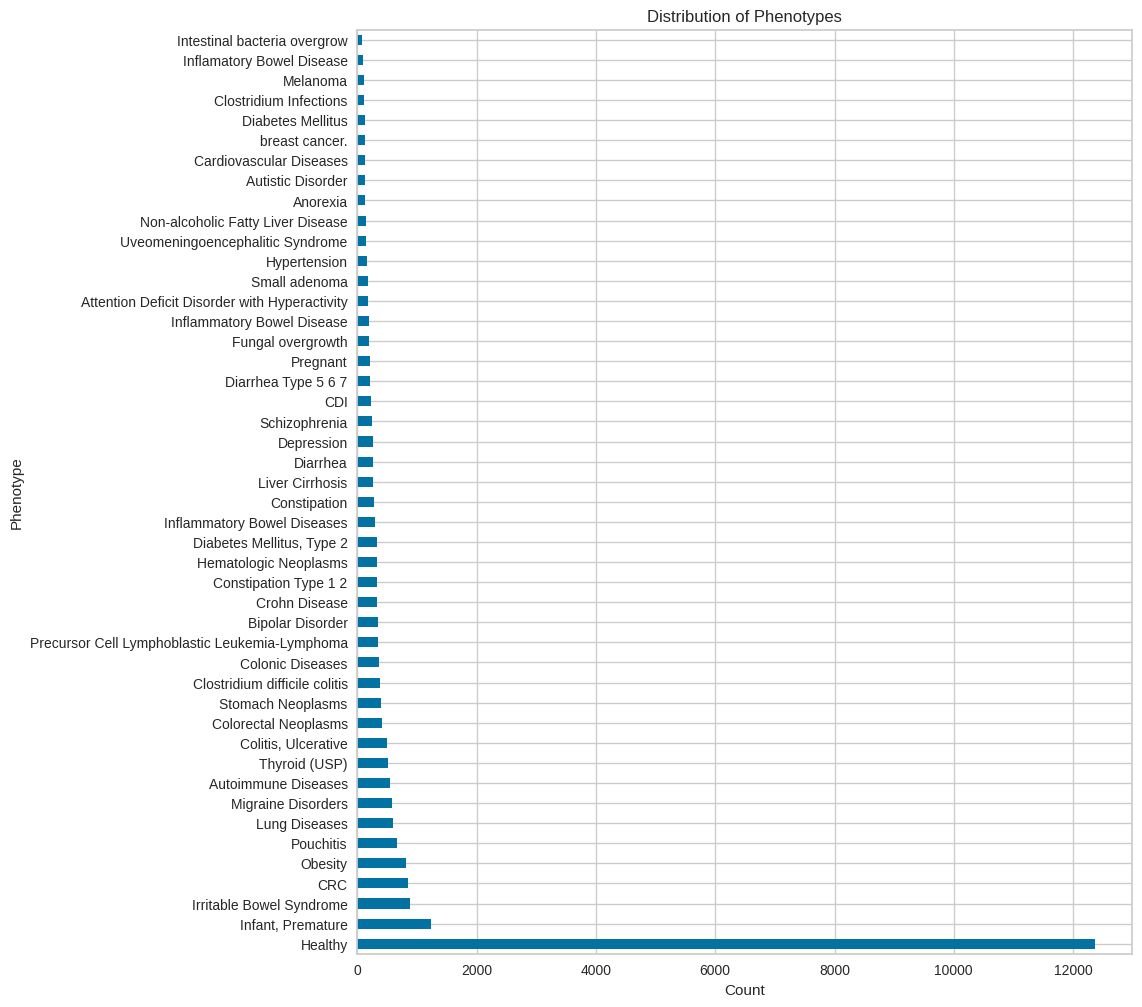

In [15]:
# plot phenotype counts

plt.figure(figsize=(10, 12))

metadata_df['phenotype'].value_counts().plot(kind='barh')

plt.xlabel('Count')
plt.ylabel('Phenotype')
plt.title('Distribution of Phenotypes')

plt.show()

Heavily unbalanced data.

### PCA of healthy samples

In [16]:
#subset healthy samples from both dfs

healthy_metadata = metadata_df[metadata_df["phenotype"] == "Healthy"]
pivoted_df_Healthy = pivoted_df_filtered.loc[healthy_metadata.index] #use healthy_metadata index to subset pivoted_df_filtered by the index

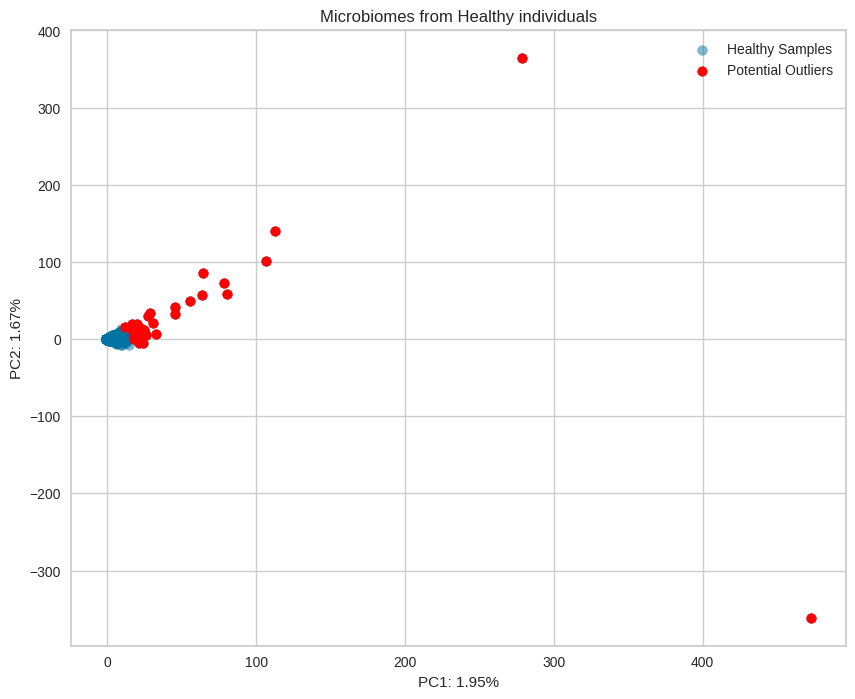

In [17]:
# Convert column names to strings
pivoted_df_Healthy.columns = pivoted_df_Healthy.columns.astype(str)

# Standardize data
scaler = StandardScaler()
pivoted_df_Healthy_standardized = scaler.fit_transform(pivoted_df_Healthy)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivoted_df_Healthy_standardized)

# Create a DataFrame with standardized PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Calculate Z-scores for each PC
z_scores = zscore(pca_df)

# Set a threshold for Z-scores to identify outliers (e.g., threshold = 3)
outlier_threshold = 3
outliers = (z_scores > outlier_threshold).any(axis=1)

# Identify outlier samples
outlier_samples = pca_df[outliers]

# Scatter plot of standardized PCA results
plt.figure(figsize=(10, 8))

# Show the percentage of variation explained by each PC
explained_var_ratio = pca.explained_variance_ratio_
plt.title(f'Microbiomes from Healthy individuals')
plt.xlabel(f'PC1: {explained_var_ratio[0]*100:.2f}%')
plt.ylabel(f'PC2: {explained_var_ratio[1]*100:.2f}%')

# Scatter plot of standardized PCA results
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5, label='Healthy Samples')
plt.scatter(outlier_samples['PC1'], outlier_samples['PC2'], color='red', label='Potential Outliers')

plt.legend()
plt.show()


In [18]:
outliers

0        False
1        False
2        False
3        False
4        False
         ...  
12371    False
12372    False
12373    False
12374    False
12375    False
Length: 12376, dtype: bool

### Remove outliers from healthy dataset

In [19]:
# Reset the index on outliers Series
outliers_reset = outliers.reset_index(drop=True)

pivoted_df_Healthy = pivoted_df_Healthy.reset_index(drop=True)
healthy_metadata = healthy_metadata.reset_index(drop=True)

# Filter rows in both DataFrames based on outliers_reset Series
pivoted_df_Healthy = pivoted_df_Healthy[~outliers_reset]
healthy_metadata = healthy_metadata[~outliers_reset]

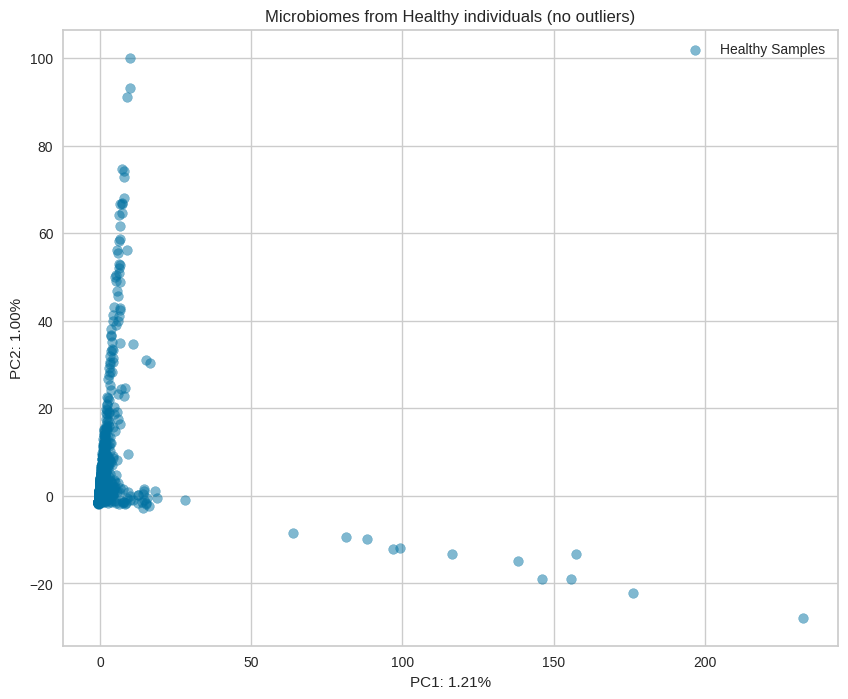

In [20]:
# Convert column names to strings
pivoted_df_Healthy.columns = pivoted_df_Healthy.columns.astype(str)

# Standardize data
scaler = StandardScaler()
pivoted_df_Healthy_standardized = scaler.fit_transform(pivoted_df_Healthy)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivoted_df_Healthy_standardized)

# Create a DataFrame with standardized PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Scatter plot of standardized PCA results
plt.figure(figsize=(10, 8))

# Show the percentage of variation explained by each PC
explained_var_ratio = pca.explained_variance_ratio_
plt.title(f'Microbiomes from Healthy individuals (no outliers)')
plt.xlabel(f'PC1: {explained_var_ratio[0]*100:.2f}%')
plt.ylabel(f'PC2: {explained_var_ratio[1]*100:.2f}%')

# Scatter plot of standardized PCA results
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5, label='Healthy Samples')

plt.legend()
plt.show()

Removing outliers made a big difference!

### PCA of all non healthy samples

In [21]:
#subset healthy samples from both dfs

non_healthy_metadata = metadata_df[metadata_df["phenotype"] != "Healthy"]
pivoted_df_non_Healthy = pivoted_df_filtered.loc[non_healthy_metadata.index] #use non_healthy_metadata index to subset pivoted_df_filtered by the index

In [22]:
# phenotypes: Separate labels into "Healthy" and "Non-Healthy"

phenotype_labels_healthy = healthy_metadata[["phenotype", "uid"]]
phenotype_labels_non_healthy = non_healthy_metadata[["phenotype", "uid"]]

In [23]:
# Reset indexes

phenotype_labels_healthy = phenotype_labels_healthy.reset_index(drop=True)

pivoted_df_non_Healthy = pivoted_df_non_Healthy.reset_index(drop=True)
phenotype_labels_non_healthy = phenotype_labels_non_healthy.reset_index(drop=True)

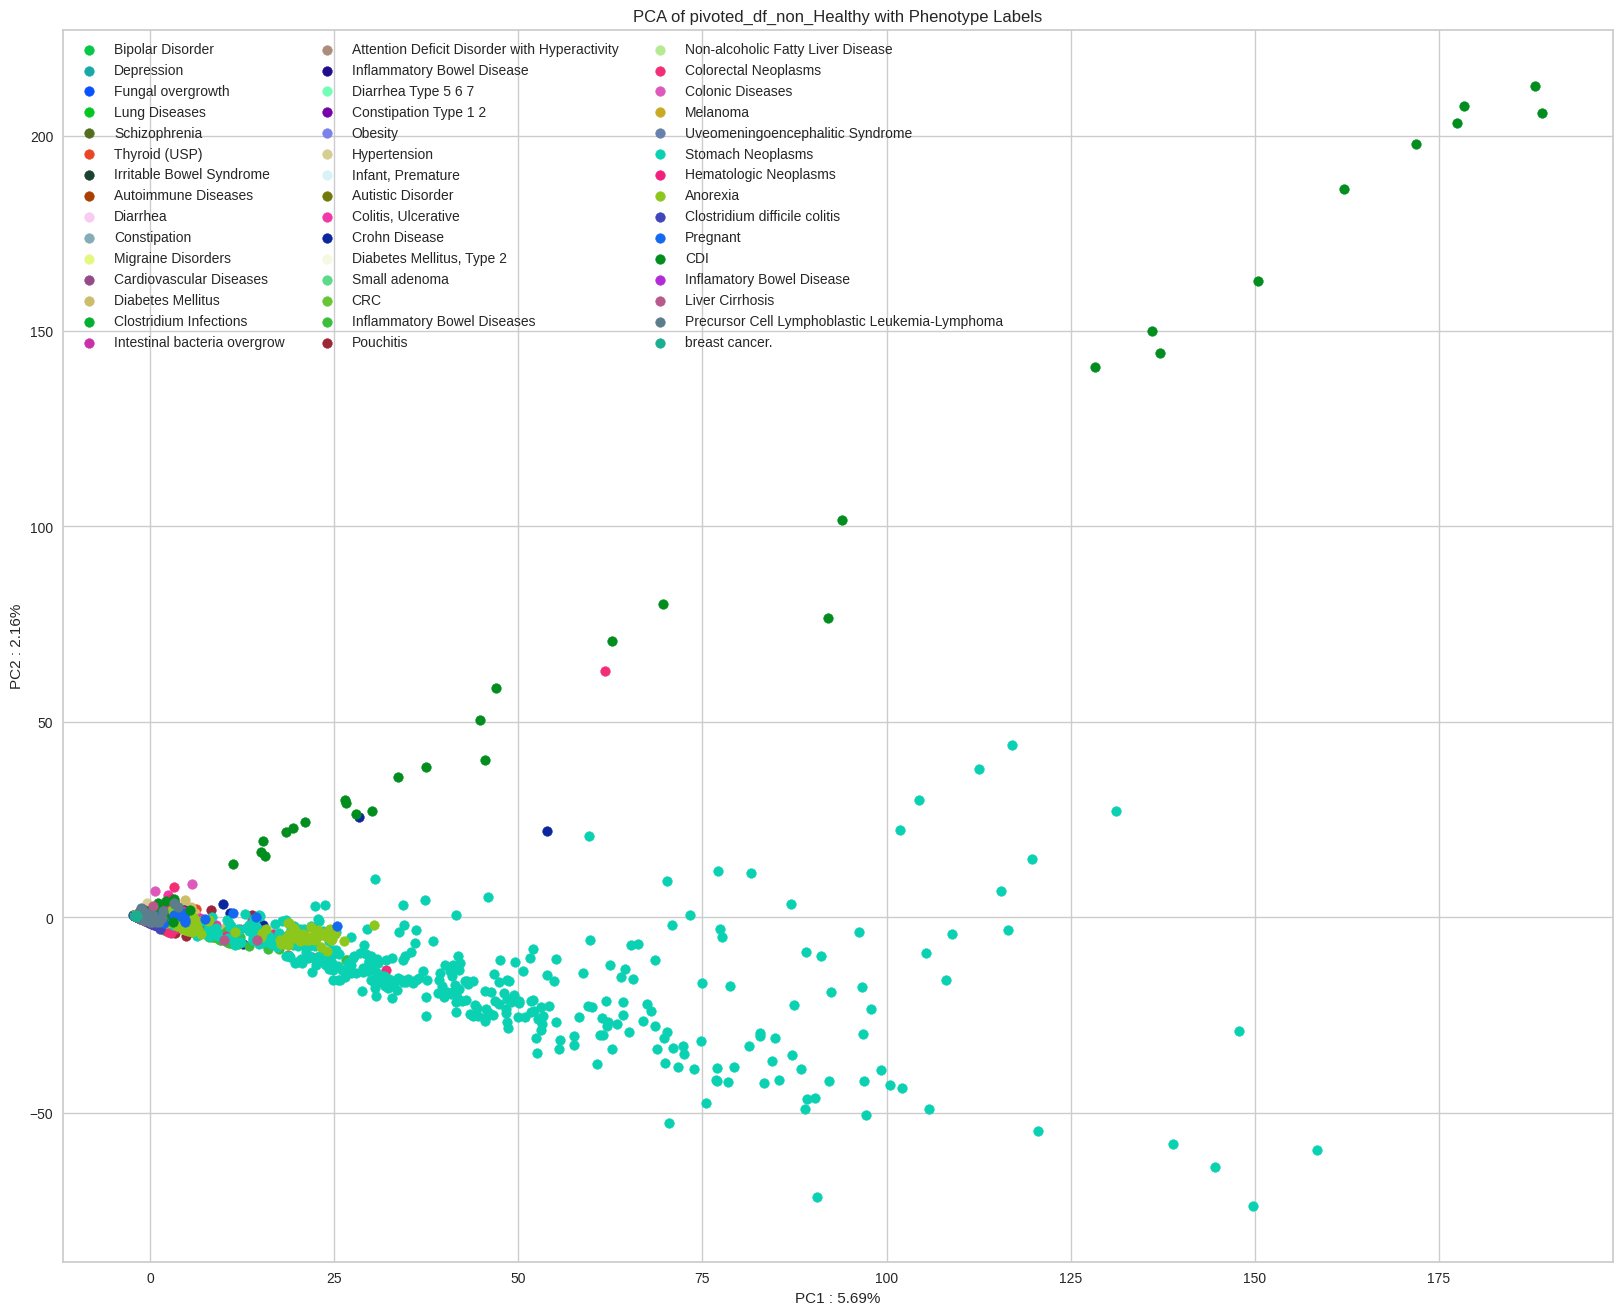

In [24]:
random.seed(420)

# Convert column names to strings
pivoted_df_non_Healthy.columns = pivoted_df_non_Healthy.columns.astype(str)

# Standardize the data
scaler = StandardScaler()
pivoted_df_non_Healthy_standardized = scaler.fit_transform(pivoted_df_non_Healthy)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivoted_df_non_Healthy_standardized)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Concatenate with labels
pca_df_with_labels = pd.concat([pca_df, phenotype_labels_non_healthy['phenotype']], axis=1)

# Use unique labels as categories
unique_labels = pca_df_with_labels['phenotype'].unique()

# Generate len(unique_phenotypes) random colors
colors = [tuple(random.uniform(0, 1) for _ in range(3)) for _ in range(len(unique_labels))]

# Create a color mapping for each unique label
label_colors = {label: colors[i] for i, label in enumerate(unique_labels)}

# Plot the PCA results with labels and colors
plt.figure(figsize=(20, 16))
for label, color in label_colors.items():
    subset = pca_df_with_labels[pca_df_with_labels['phenotype'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label, color=color)

# Display percentage of variance explained by each PC
explained_var_ratio = pca.explained_variance_ratio_
pc1_var = explained_var_ratio[0]* 100
pc2_var = explained_var_ratio[1]* 100

plt.title('PCA of pivoted_df_non_Healthy with Phenotype Labels')
plt.xlabel(f'PC1 : {round(pc1_var, 2)}%')
plt.ylabel(f'PC2 : {round(pc2_var, 2)}%')
plt.legend(ncol=3)

plt.show()

Some clear differences here: Anorexia, CDI, Stomach Neoplasms...

## Healthy vs mental ilness

In [25]:
# Subset mental illnessess

mental_illnesses = ["Bipolar Disorder", "Depression", "Schizophrenia", "Migraine Disorders", 
                   "Attention Deficit Disorder with Hyperactivity", "Autistic Disorder", "Anorexia"]

is_in_mental_illnesses = phenotype_labels_non_healthy['phenotype'].isin(mental_illnesses)

#data
subset_pivoted_df_mental_illnesses = pivoted_df_non_Healthy[is_in_mental_illnesses]

#labels
subset_mental_illnesses_phenotype_labels = phenotype_labels_non_healthy[is_in_mental_illnesses]
subset_mental_illnesses_phenotype_labels['phenotype'].unique()

array(['Bipolar Disorder', 'Depression', 'Schizophrenia',
       'Migraine Disorders',
       'Attention Deficit Disorder with Hyperactivity',
       'Autistic Disorder', 'Anorexia'], dtype=object)

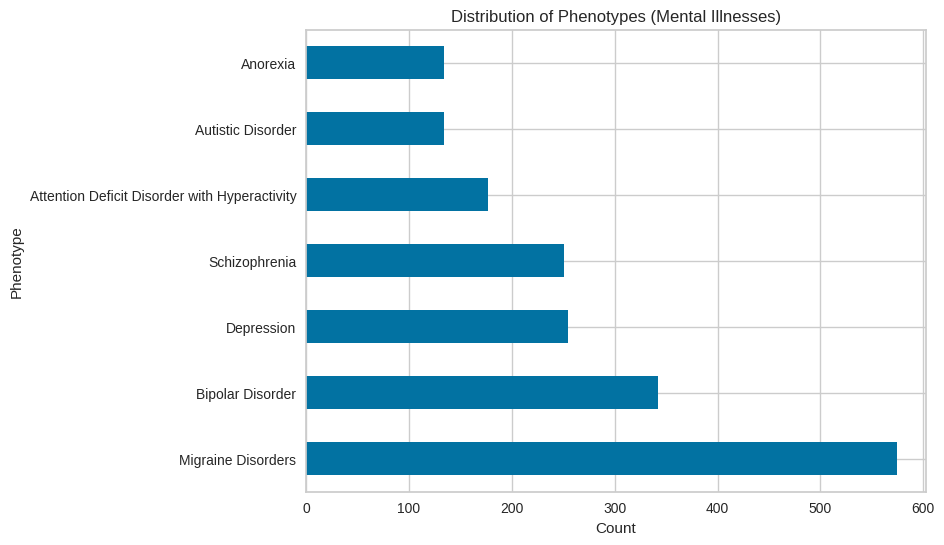

In [26]:
# plot phenotype counts

plt.figure(figsize=(8, 6))

subset_mental_illnesses_phenotype_labels['phenotype'].value_counts().plot(kind='barh')

plt.xlabel('Count')
plt.ylabel('Phenotype')
plt.title('Distribution of Phenotypes (Mental Illnesses)')

plt.show()

In [27]:
# Concatenate mental ilnessess with healthy dfs

concatenated_pivoted_df = pd.concat([subset_pivoted_df_mental_illnesses, pivoted_df_Healthy])
concatenated_phenotype_labels = pd.concat([subset_mental_illnesses_phenotype_labels, phenotype_labels_healthy])

concatenated_pivoted_df = concatenated_pivoted_df.reset_index(drop=True)
concatenated_phenotype_labels = concatenated_phenotype_labels.reset_index(drop=True)

### PCA of mental illnessess vs healthy samples

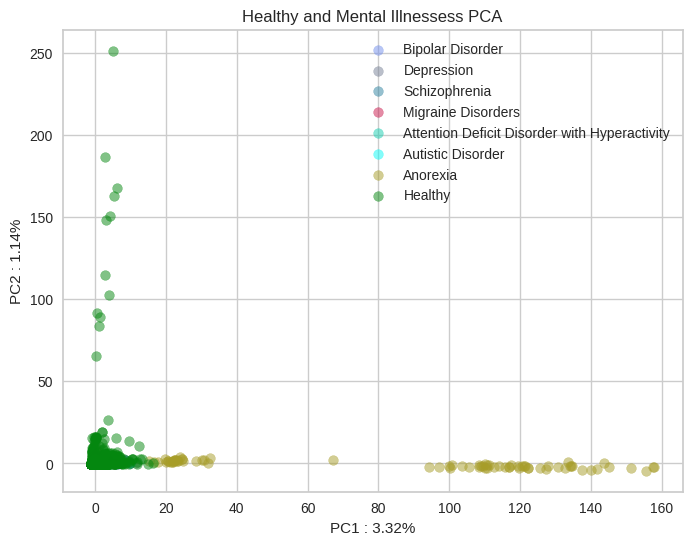

In [28]:
random.seed(11)

# Convert column names to strings
concatenated_pivoted_df.columns = concatenated_pivoted_df.columns.astype(str)

# Standardize the data
scaler = StandardScaler()
concatenated_pivoted_df_standardized = scaler.fit_transform(concatenated_pivoted_df)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(concatenated_pivoted_df_standardized)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Concatenate with labels
pca_df_with_labels = pd.concat([pca_df, concatenated_phenotype_labels['phenotype']], axis=1)

# Use unique labels as categories
unique_labels = pca_df_with_labels['phenotype'].unique()

# Generate len(unique_phenotypes) random colors
colors = [tuple(random.uniform(0, 1) for _ in range(3)) for _ in range(len(unique_labels))]

# Create a color mapping for each unique label
label_colors = {label: colors[i] for i, label in enumerate(unique_labels)}

# Plot the PCA results with labels and colors
plt.figure(figsize=(8, 6))
for label, color in label_colors.items():
    subset = pca_df_with_labels[pca_df_with_labels['phenotype'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label, color=color, alpha=0.5)  # Adding alpha for transparency

# Display percentage of variance explained by each PC
explained_var_ratio = pca.explained_variance_ratio_
pc1_var = explained_var_ratio[0]* 100
pc2_var = explained_var_ratio[1]* 100

plt.title('Healthy and Mental Illnessess PCA')
plt.xlabel(f'PC1 : {round(pc1_var, 2)}%')
plt.ylabel(f'PC2 : {round(pc2_var, 2)}%')
plt.legend()

plt.show()

Not much differentiation, except for Anorexia. This makes sense as anorexia has severe gastrointestinal consequences.

### Build a binary classifier for each disease (test for 1 disease at a time)

### 1) subset data

In [29]:
# select a disease

# ((( [IF CHANGING subset_mental_illnesses_phenotype_labels FOR phenotype_labels_non_healthy] 
# AND
# [subset_pivoted_df_mental_illnesses FOR pivoted_df_non_Healthy]
# ALL DISEASES CAN BE ACCESSED! )))

element = phenotype_labels_non_healthy['phenotype'].unique()[-8]# iterate here 
is_in_element = phenotype_labels_non_healthy['phenotype'] == (element)

# subset data
mi = pivoted_df_non_Healthy[is_in_element]
# subset labels
mi_labels = phenotype_labels_non_healthy[is_in_element]

print(element)

Anorexia


### 2) feature selection

In [30]:
# Initialize an empty DataFrame to store results
signif_kw_results = pd.DataFrame(columns=['Column_Name', 'P_Value'])

# Iterate through each column in pivoted_df_Healthy
for column_name in pivoted_df_Healthy.columns:
    # Check for unique values in each group
    unique_values_pivoted = pivoted_df_Healthy[column_name].unique()
    unique_values_mi = mi[column_name].unique()
    
    # If either group has only one unique value, skip the test for this column
    if len(unique_values_pivoted) > 1 and len(unique_values_mi) > 1:
        # Perform Kruskal-Wallis test
        _, p_value = kruskal(pivoted_df_Healthy[column_name], mi[column_name])
        
        # Check if p-value is less than 0.05
        if p_value < 0.05:
            # Append results to kw_results DataFrame
            signif_kw_results = signif_kw_results.append({'Column_Name': column_name, 'P_Value': p_value}, ignore_index=True)

signif_kw_results

,Column_Name,P_Value
0,Cellvibrio,8.989488e-12
1,Dictyoglomus,9.844043e-03
2,Pelobacter,2.854173e-101
3,Shewanella,2.776633e-05
4,Myxococcus,9.920231e-43
...,...,...
695,2048137,3.128197e-36
696,2057233,2.177862e-22
697,2070447,3.005562e-04
698,2282523,3.335988e-02


In [31]:
# Keep significant features

# Extract the column names to keep
columns_to_keep = signif_kw_results["Column_Name"].tolist()

# Filter columns in pivoted_df_Healthy and mi
filtered_pivoted_df_Healthy = pivoted_df_Healthy.filter(columns_to_keep, axis=1)
filtered_mi = mi.filter(columns_to_keep, axis=1)

In [32]:
#concat with healthy samples
mi_concatenated_pivoted_df = pd.concat([filtered_pivoted_df_Healthy, filtered_mi])
mi_concatenated_phenotype_labels = pd.concat([phenotype_labels_healthy, mi_labels, ])

mi_concatenated_pivoted_df = mi_concatenated_pivoted_df.reset_index(drop=True)
mi_concatenated_phenotype_labels = mi_concatenated_phenotype_labels.reset_index(drop=True)

### 3) PCA of selected disease against healthy samples

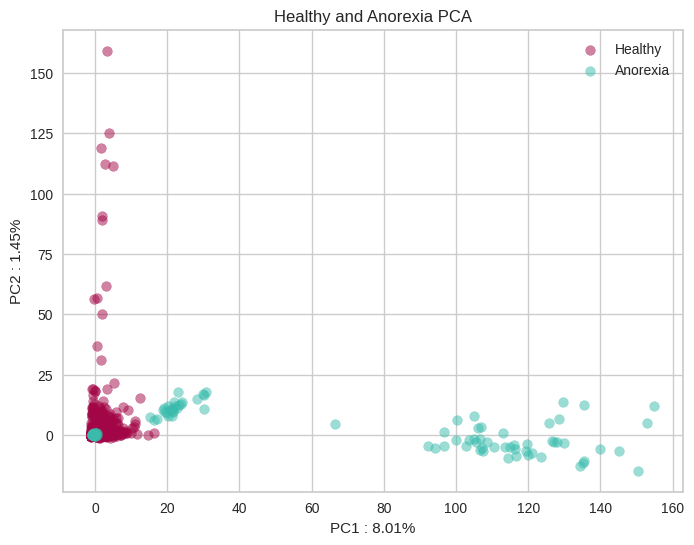

In [33]:
random.seed(42)

# Convert column names to strings
mi_concatenated_pivoted_df.columns = mi_concatenated_pivoted_df.columns.astype(str)

# Standardize the data
scaler = StandardScaler()
mi_concatenated_pivoted_df_standardized = scaler.fit_transform(mi_concatenated_pivoted_df)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(mi_concatenated_pivoted_df_standardized)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Concatenate with labels
pca_df_with_labels = pd.concat([pca_df, mi_concatenated_phenotype_labels['phenotype']], axis=1)

# Use unique labels as categories
unique_labels = pca_df_with_labels['phenotype'].unique()

# Generate len(unique_phenotypes) random colors
colors = [tuple(random.uniform(0, 1) for _ in range(3)) for _ in range(len(unique_labels))]

# Create a color mapping for each unique label
label_colors = {label: colors[i] for i, label in enumerate(unique_labels)}

# Plot the PCA results with labels and colors
plt.figure(figsize=(8, 6))
for label, color in label_colors.items():
    subset = pca_df_with_labels[pca_df_with_labels['phenotype'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label, color=color, alpha=0.5)  # Adding alpha for transparency

# Display percentage of variance explained by each PC
explained_var_ratio = pca.explained_variance_ratio_
pc1_var = explained_var_ratio[0]* 100
pc2_var = explained_var_ratio[1]* 100

plt.title(f'Healthy and {element} PCA')
plt.xlabel(f'PC1 : {round(pc1_var, 2)}%')
plt.ylabel(f'PC2 : {round(pc2_var, 2)}%')
plt.legend()

plt.savefig(f'{element}.png')

plt.show()

### 4) train ML model

In [34]:
# Calculate and print the percentage of each unique class
class_percentages = mi_concatenated_phenotype_labels["phenotype"].value_counts(normalize=True) * 100

for class_label, percentage in class_percentages.items():
    print(f"Class: {class_label}, Percentage: {percentage:.2f}%")

Class: Healthy, Percentage: 98.93%
Class: Anorexia, Percentage: 1.07%


In [35]:
# Replace labels with the desired mapping: Healthy always = 0 and whatever mental illness  == 1
mi_concatenated_phenotype_labels["phenotype"] = mi_concatenated_phenotype_labels["phenotype"].apply(lambda x: 0 if x == "Healthy" else 1)

In [36]:
# pycaret

exp1 = setup(mi_concatenated_pivoted_df, target=mi_concatenated_phenotype_labels["phenotype"], 
             session_id=42, remove_outliers = False, n_jobs = 6, train_size=0.7)

,Description,Value
0,Session id,42
1,Target,phenotype
2,Target type,Binary
3,Original data shape,"(12471, 701)"
4,Transformed data shape,"(12471, 701)"
5,Transformed train set shape,"(8729, 701)"
6,Transformed test set shape,"(3742, 701)"
7,Numeric features,700
8,Preprocess,True
9,Imputation type,simple


In [37]:
compare_models(exclude = ['lightgbm', 'catboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9994,0.9999,0.9467,1.0000,0.9705,0.9702,0.9717,0.7870
xgboost,Extreme Gradient Boosting,0.9989,0.9998,0.8933,1.0000,0.9374,0.9369,0.9415,1.7840
gbc,Gradient Boosting Classifier,0.9969,0.9984,0.7911,0.9249,0.8391,0.8376,0.8470,3.4280
et,Extra Trees Classifier,0.9964,0.9998,0.6744,1.0000,0.7997,0.7980,0.8167,0.3510
lr,Logistic Regression,0.9961,0.9987,0.7422,0.8917,0.8007,0.7988,0.8069,2.1110
rf,Random Forest Classifier,0.9961,0.9999,0.6422,1.0000,0.7691,0.7674,0.7929,0.2150
dt,Decision Tree Classifier,0.9960,0.9051,0.8122,0.8350,0.8117,0.8097,0.8157,0.1800
knn,K Neighbors Classifier,0.9954,0.9712,0.7533,0.8021,0.7702,0.7680,0.7717,0.2550
ridge,Ridge Classifier,0.9937,0.0000,0.5033,0.8737,0.6242,0.6214,0.6522,0.1170
lda,Linear Discriminant Analysis,0.9905,0.9003,0.5878,0.5604,0.5631,0.5584,0.5639,0.2750


AdaBoostClassifier(algorithm='SAMME.R', base_estimator='deprecated',
                   estimator=None, learning_rate=1.0, n_estimators=50,
                   random_state=42)

In [38]:
ml_results = pull()
ml_results["disease"] = element

In [39]:
ml_results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),disease
ada,Ada Boost Classifier,0.9994,0.9999,0.9467,1.0000,0.9705,0.9702,0.9717,0.787,Anorexia
xgboost,Extreme Gradient Boosting,0.9989,0.9998,0.8933,1.0000,0.9374,0.9369,0.9415,1.784,Anorexia
gbc,Gradient Boosting Classifier,0.9969,0.9984,0.7911,0.9249,0.8391,0.8376,0.8470,3.428,Anorexia
et,Extra Trees Classifier,0.9964,0.9998,0.6744,1.0000,0.7997,0.7980,0.8167,0.351,Anorexia
lr,Logistic Regression,0.9961,0.9987,0.7422,0.8917,0.8007,0.7988,0.8069,2.111,Anorexia
rf,Random Forest Classifier,0.9961,0.9999,0.6422,1.0000,0.7691,0.7674,0.7929,0.215,Anorexia
dt,Decision Tree Classifier,0.9960,0.9051,0.8122,0.8350,0.8117,0.8097,0.8157,0.180,Anorexia
knn,K Neighbors Classifier,0.9954,0.9712,0.7533,0.8021,0.7702,0.7680,0.7717,0.255,Anorexia
ridge,Ridge Classifier,0.9937,0.0000,0.5033,0.8737,0.6242,0.6214,0.6522,0.117,Anorexia
lda,Linear Discriminant Analysis,0.9905,0.9003,0.5878,0.5604,0.5631,0.5584,0.5639,0.275,Anorexia


## LOOP THROUGH EACH DISEASE

In [40]:
ml_results = pd.DataFrame()

# Iterate through each disease
for element in tqdm(phenotype_labels_non_healthy['phenotype'].unique()):
    
    ### 1) subset data
    is_in_element = phenotype_labels_non_healthy['phenotype'] == element
    mi = pivoted_df_non_Healthy[is_in_element]
    mi_labels = phenotype_labels_non_healthy[is_in_element]

    print("\n############################")
    print("Processing " + element)
    
    ### 2) feature selection
    
    # Initialize an empty DataFrame to store results
    signif_kw_results = pd.DataFrame(columns=['Column_Name', 'P_Value'])
    
    # Iterate through each column in pivoted_df_Healthy
    for column_name in pivoted_df_Healthy.columns:
        # Check for unique values in each group
        unique_values_pivoted = pivoted_df_Healthy[column_name].unique()
        unique_values_mi = mi[column_name].unique()
        
        # If either group has only one unique value, skip the test for this column
        if len(unique_values_pivoted) > 1 and len(unique_values_mi) > 1:
            # Perform Kruskal-Wallis test
            _, p_value = kruskal(pivoted_df_Healthy[column_name], mi[column_name])
            
            # Check if p-value is less than 0.05
            if p_value < 0.05:
                # Append results to kw_results DataFrame
                signif_kw_results = signif_kw_results.append({'Column_Name': column_name, 'P_Value': p_value}, ignore_index=True)
    
    # Keep significant features
    
    # Extract the column names to keep
    columns_to_keep = signif_kw_results["Column_Name"].tolist()
    
    # Filter columns in pivoted_df_Healthy and mi
    filtered_pivoted_df_Healthy = pivoted_df_Healthy.filter(columns_to_keep, axis=1)
    filtered_mi = mi.filter(columns_to_keep, axis=1)
    
    #concat with healthy samples
    mi_concatenated_pivoted_df = pd.concat([filtered_pivoted_df_Healthy, filtered_mi])
    mi_concatenated_phenotype_labels = pd.concat([phenotype_labels_healthy, mi_labels, ])
    
    mi_concatenated_pivoted_df = mi_concatenated_pivoted_df.reset_index(drop=True)
    mi_concatenated_phenotype_labels = mi_concatenated_phenotype_labels.reset_index(drop=True)
    
    ### 3) PCA of selected disease against healthy samples
    
    random.seed(42)
    
    # Convert column names to strings
    mi_concatenated_pivoted_df.columns = mi_concatenated_pivoted_df.columns.astype(str)
    
    # Standardize the data
    scaler = StandardScaler()
    mi_concatenated_pivoted_df_standardized = scaler.fit_transform(mi_concatenated_pivoted_df)
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(mi_concatenated_pivoted_df_standardized)
    
    # Create a DataFrame with PCA results
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    
    # Concatenate with labels
    pca_df_with_labels = pd.concat([pca_df, mi_concatenated_phenotype_labels['phenotype']], axis=1)
    
    # Use unique labels as categories
    unique_labels = pca_df_with_labels['phenotype'].unique()
    
    # Generate len(unique_phenotypes) random colors
    colors = [tuple(random.uniform(0, 1) for _ in range(3)) for _ in range(len(unique_labels))]
    
    # Create a color mapping for each unique label
    label_colors = {label: colors[i] for i, label in enumerate(unique_labels)}
    
    # Plot the PCA results with labels and colors
    plt.figure(figsize=(8, 6))
    for label, color in label_colors.items():
        subset = pca_df_with_labels[pca_df_with_labels['phenotype'] == label]
        plt.scatter(subset['PC1'], subset['PC2'], label=label, color=color, alpha=0.5)  # Adding alpha for transparency
    
    # Display percentage of variance explained by each PC
    explained_var_ratio = pca.explained_variance_ratio_
    pc1_var = explained_var_ratio[0]* 100
    pc2_var = explained_var_ratio[1]* 100
    
    plt.title(f'Healthy and {element} PCA')
    plt.xlabel(f'PC1 : {round(pc1_var, 2)}%')
    plt.ylabel(f'PC2 : {round(pc2_var, 2)}%')
    plt.legend()
    
    plt.savefig(f'{element}.png')
    
    ### 4) train ML model
    
    # Calculate and print the percentage of each unique class
    class_percentages = mi_concatenated_phenotype_labels["phenotype"].value_counts(normalize=True) * 100
    
    for class_label, percentage in class_percentages.items():
        print(f"Class: {class_label}: {percentage:.2f}%")
    
    # Replace labels with the desired mapping: Healthy always = 0 and whatever mental illness  == 1
    mi_concatenated_phenotype_labels["phenotype"] = mi_concatenated_phenotype_labels["phenotype"].apply(lambda x: 0 if x == "Healthy" else 1)
    
    # pycaret
    exp1 = setup(mi_concatenated_pivoted_df, target=mi_concatenated_phenotype_labels["phenotype"], 
                 session_id=42, remove_outliers = False, n_jobs = 6, train_size=0.7, verbose=False)

    print("Training models...")
    compare_models(exclude = ['lightgbm', 'catboost'], verbose=False)
    
    ml_results_temp = pull()
    ml_results_temp["disease"] = element
    
    # Append results to ml_results DataFrame
    ml_results = ml_results.append(ml_results_temp, ignore_index=True)

  0%|                                                    | 0/45 [00:00<?, ?it/s]


############################
Processing Bipolar Disorder
Class: Healthy: 97.30%
Class: Bipolar Disorder: 2.70%
Training models...


  2%|▉                                        | 1/45 [02:05<1:32:03, 125.53s/it]


############################
Processing Depression
Class: Healthy: 97.97%
Class: Depression: 2.03%
Training models...


  4%|█▊                                       | 2/45 [04:14<1:31:20, 127.44s/it]


############################
Processing Fungal overgrowth
Class: Healthy: 98.46%
Class: Fungal overgrowth: 1.54%
Training models...


  7%|██▋                                      | 3/45 [05:51<1:19:34, 113.69s/it]


############################
Processing Lung Diseases
Class: Healthy: 95.42%
Class: Lung Diseases: 4.58%
Training models...


  9%|███▋                                     | 4/45 [08:13<1:25:13, 124.72s/it]


############################
Processing Schizophrenia
Class: Healthy: 98.01%
Class: Schizophrenia: 1.99%
Training models...


 11%|████▌                                    | 5/45 [10:15<1:22:38, 123.96s/it]


############################
Processing Thyroid (USP)
Class: Healthy: 95.96%
Class: Thyroid (USP): 4.04%
Training models...


 13%|█████▍                                   | 6/45 [12:36<1:24:10, 129.50s/it]


############################
Processing Irritable Bowel Syndrome
Class: Healthy: 93.33%
Class: Irritable Bowel Syndrome: 6.67%
Training models...


 16%|██████▍                                  | 7/45 [15:11<1:27:26, 138.07s/it]


############################
Processing Autoimmune Diseases
Class: Healthy: 95.75%
Class: Autoimmune Diseases: 4.25%
Training models...


 18%|███████▎                                 | 8/45 [17:28<1:24:48, 137.52s/it]


############################
Processing Diarrhea
Class: Healthy: 97.97%
Class: Diarrhea: 2.03%
Training models...


 20%|████████▏                                | 9/45 [19:15<1:16:51, 128.11s/it]


############################
Processing Constipation
Class: Healthy: 97.75%
Class: Constipation: 2.25%
Training models...


 22%|████████▉                               | 10/45 [21:21<1:14:23, 127.54s/it]


############################
Processing Migraine Disorders
Class: Healthy: 95.55%
Class: Migraine Disorders: 4.45%
Training models...


 24%|█████████▊                              | 11/45 [23:39<1:14:04, 130.71s/it]


############################
Processing Cardiovascular Diseases
Class: Healthy: 98.93%
Class: Cardiovascular Diseases: 1.07%
Training models...


 27%|██████████▋                             | 12/45 [25:03<1:03:56, 116.26s/it]


############################
Processing Diabetes Mellitus
Class: Healthy: 99.01%
Class: Diabetes Mellitus: 0.99%
Training models...


 29%|████████████▏                             | 13/45 [26:38<58:35, 109.87s/it]


############################
Processing Clostridium Infections
Class: Healthy: 99.08%
Class: Clostridium Infections: 0.92%
Training models...


 31%|█████████████▍                             | 14/45 [27:53<51:23, 99.48s/it]


############################
Processing Intestinal bacteria overgrow
Class: Healthy: 99.39%
Class: Intestinal bacteria overgrow: 0.61%
Training models...


 33%|██████████████▎                            | 15/45 [28:55<44:06, 88.21s/it]


############################
Processing Attention Deficit Disorder with Hyperactivity
Class: Healthy: 98.59%
Class: Attention Deficit Disorder with Hyperactivity: 1.41%
Training models...


 36%|███████████████▎                           | 16/45 [30:41<45:10, 93.48s/it]


############################
Processing Inflammatory Bowel Disease
Class: Healthy: 98.48%
Class: Inflammatory Bowel Disease: 1.52%
Training models...


 38%|████████████████▏                          | 17/45 [32:20<44:21, 95.05s/it]


############################
Processing Diarrhea Type 5 6 7
Class: Healthy: 98.29%
Class: Diarrhea Type 5 6 7: 1.71%
Training models...


 40%|█████████████████▏                         | 18/45 [33:57<43:06, 95.79s/it]


############################
Processing Constipation Type 1 2
Class: Healthy: 97.42%
Class: Constipation Type 1 2: 2.58%
Training models...


 42%|█████████████████▋                        | 19/45 [36:01<45:06, 104.09s/it]


############################
Processing Obesity
Class: Healthy: 93.81%
Class: Obesity: 6.19%
Training models...


 44%|██████████████████▋                       | 20/45 [38:48<51:21, 123.24s/it]


############################
Processing Hypertension
Class: Healthy: 98.75%
Class: Hypertension: 1.25%
Training models...


 47%|███████████████████▌                      | 21/45 [39:38<40:24, 101.02s/it]


############################
Processing Infant, Premature
Class: Healthy: 90.89%
Class: Infant, Premature: 9.11%
Training models...


 49%|█████████████████████                      | 22/45 [40:26<32:42, 85.33s/it]


############################
Processing Autistic Disorder
Class: Healthy: 98.93%
Class: Autistic Disorder: 1.07%
Training models...


 51%|█████████████████████▉                     | 23/45 [42:31<35:39, 97.25s/it]


############################
Processing Colitis, Ulcerative
Class: Healthy: 96.18%
Class: Colitis, Ulcerative: 3.82%
Training models...


 53%|██████████████████████▍                   | 24/45 [44:57<39:07, 111.78s/it]


############################
Processing Crohn Disease
Class: Healthy: 97.39%
Class: Crohn Disease: 2.61%
Training models...


 56%|███████████████████████▎                  | 25/45 [47:53<43:40, 131.05s/it]


############################
Processing Diabetes Mellitus, Type 2
Class: Healthy: 97.43%
Class: Diabetes Mellitus, Type 2: 2.57%
Training models...


 58%|████████████████████████▎                 | 26/45 [50:13<42:22, 133.79s/it]


############################
Processing Small adenoma
Class: Healthy: 98.63%
Class: Small adenoma: 1.37%
Training models...


 60%|█████████████████████████▏                | 27/45 [52:01<37:45, 125.84s/it]


############################
Processing CRC
Class: Healthy: 93.60%
Class: CRC: 6.40%
Training models...


 62%|██████████████████████████▏               | 28/45 [55:15<41:26, 146.26s/it]


############################
Processing Inflammatory Bowel Diseases
Class: Healthy: 97.64%
Class: Inflammatory Bowel Diseases: 2.36%
Training models...


 64%|█████████████████████████▊              | 29/45 [1:00:01<50:13, 188.36s/it]


############################
Processing Pouchitis
Class: Healthy: 94.90%
Class: Pouchitis: 5.10%
Training models...


 67%|██████████████████████████▋             | 30/45 [1:03:35<49:00, 196.05s/it]


############################
Processing Non-alcoholic Fatty Liver Disease
Class: Healthy: 98.86%
Class: Non-alcoholic Fatty Liver Disease: 1.14%
Training models...


 69%|███████████████████████████▌            | 31/45 [1:05:08<38:30, 165.02s/it]


############################
Processing Colorectal Neoplasms
Class: Healthy: 96.76%
Class: Colorectal Neoplasms: 3.24%
Training models...


 71%|████████████████████████████▍           | 32/45 [1:08:28<38:01, 175.53s/it]


############################
Processing Colonic Diseases
Class: Healthy: 97.16%
Class: Colonic Diseases: 2.84%
Training models...


 73%|█████████████████████████████▎          | 33/45 [1:10:17<31:06, 155.51s/it]


############################
Processing Melanoma
Class: Healthy: 99.16%
Class: Melanoma: 0.84%
Training models...


 76%|██████████████████████████████▏         | 34/45 [1:11:22<23:32, 128.45s/it]


############################
Processing Uveomeningoencephalitic Syndrome
Class: Healthy: 98.80%
Class: Uveomeningoencephalitic Syndrome: 1.20%
Training models...


 78%|███████████████████████████████         | 35/45 [1:12:15<17:39, 105.98s/it]


############################
Processing Stomach Neoplasms
Class: Healthy: 96.95%
Class: Stomach Neoplasms: 3.05%
Training models...


 80%|████████████████████████████████        | 36/45 [1:14:38<17:32, 116.89s/it]


############################
Processing Hematologic Neoplasms
Class: Healthy: 97.43%
Class: Hematologic Neoplasms: 2.57%
Training models...


 82%|████████████████████████████████▉       | 37/45 [1:16:17<14:53, 111.63s/it]


############################
Processing Anorexia
Class: Healthy: 98.93%
Class: Anorexia: 1.07%
Training models...


 84%|█████████████████████████████████▊      | 38/45 [1:18:23<13:30, 115.77s/it]


############################
Processing Clostridium difficile colitis
Class: Healthy: 96.97%
Class: Clostridium difficile colitis: 3.03%
Training models...


 87%|██████████████████████████████████▋     | 39/45 [1:20:28<11:52, 118.74s/it]


############################
Processing Pregnant
Class: Healthy: 98.37%
Class: Pregnant: 1.63%
Training models...


 89%|███████████████████████████████████▌    | 40/45 [1:22:47<10:23, 124.71s/it]


############################
Processing CDI
Class: Healthy: 98.18%
Class: CDI: 1.82%
Training models...


 91%|████████████████████████████████████▍   | 41/45 [1:24:56<08:24, 126.09s/it]


############################
Processing Inflamatory Bowel Disease
Class: Healthy: 99.19%
Class: Inflamatory Bowel Disease: 0.81%
Training models...


 93%|█████████████████████████████████████▎  | 42/45 [1:26:04<05:26, 108.75s/it]


############################
Processing Liver Cirrhosis
Class: Healthy: 97.87%
Class: Liver Cirrhosis: 2.13%
Training models...


 96%|██████████████████████████████████████▏ | 43/45 [1:28:09<03:47, 113.60s/it]


############################
Processing Precursor Cell Lymphoblastic Leukemia-Lymphoma
Class: Healthy: 97.22%
Class: Precursor Cell Lymphoblastic Leukemia-Lymphoma: 2.78%
Training models...


 98%|███████████████████████████████████████ | 44/45 [1:29:55<01:51, 111.29s/it]


############################
Processing breast cancer.
Class: Healthy: 98.93%
Class: breast cancer.: 1.07%
Training models...


100%|████████████████████████████████████████| 45/45 [1:30:42<00:00, 120.94s/it]


In [43]:
#export results

# ml_results.to_csv('ml_results.csv', index=False)

### Evaluate results

In [41]:
ml_results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),disease
0,Random Forest Classifier,0.9731,0.9211,0.0000,0.0000,0.0000,0.0000,0.0000,0.344,Bipolar Disorder
1,Dummy Classifier,0.9731,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.044,Bipolar Disorder
2,Extra Trees Classifier,0.9730,0.9044,0.0000,0.0000,0.0000,-0.0002,-0.0005,0.562,Bipolar Disorder
3,K Neighbors Classifier,0.9724,0.6105,0.0085,0.0833,0.0154,0.0134,0.0227,0.162,Bipolar Disorder
4,Extreme Gradient Boosting,0.9719,0.9177,0.0335,0.3433,0.0580,0.0533,0.0929,4.162,Bipolar Disorder
...,...,...,...,...,...,...,...,...,...,...
625,Quadratic Discriminant Analysis,0.9852,0.5131,0.0222,0.0050,0.0082,0.0066,0.0086,0.063,breast cancer.
626,SVM - Linear Kernel,0.9851,0.0000,0.0756,0.1524,0.0871,0.0820,0.0933,0.040,breast cancer.
627,Decision Tree Classifier,0.9838,0.6022,0.2122,0.2111,0.2039,0.1961,0.1998,0.075,breast cancer.
628,Linear Discriminant Analysis,0.9826,0.9136,0.1600,0.1649,0.1569,0.1485,0.1511,0.034,breast cancer.


In [78]:
# remove models that have any metrics value < 0.5

GOOD_ml_results = ml_results[(ml_results.iloc[:, 1:8] > 0.6).all(axis=1)]

In [79]:
# Select best model for each remaining disease based on AUC

best_auc_rows = GOOD_ml_results.loc[GOOD_ml_results.groupby('disease')['AUC'].idxmax()]

In [80]:
best_auc_rows

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),disease
518,Ada Boost Classifier,0.9994,0.9999,0.9467,1.0000,0.9705,0.9702,0.9717,0.792,Anorexia
560,Extreme Gradient Boosting,0.9973,0.9998,0.8875,0.9607,0.9207,0.9193,0.9211,2.730,CDI
378,Extreme Gradient Boosting,0.9853,0.9959,0.8034,0.9603,0.8744,0.8666,0.8708,6.404,CRC
532,Extreme Gradient Boosting,0.9932,0.9980,0.8030,0.9633,0.8729,0.8695,0.8748,3.987,Clostridium difficile colitis
448,Extreme Gradient Boosting,0.9892,0.9958,0.6758,0.9302,0.7806,0.7753,0.7868,3.912,Colonic Diseases
434,Extreme Gradient Boosting,0.9955,0.9978,0.8824,0.9777,0.9261,0.9238,0.9259,4.001,Colorectal Neoplasms
504,Extreme Gradient Boosting,0.9980,0.9997,0.9344,0.9866,0.9592,0.9581,0.9588,2.598,Hematologic Neoplasms
295,Extreme Gradient Boosting,0.9943,0.9992,0.9769,0.9615,0.9691,0.9659,0.9660,1.093,"Infant, Premature"
574,Extreme Gradient Boosting,0.9983,0.9990,0.8161,0.9690,0.8829,0.8820,0.8869,1.498,Inflamatory Bowel Disease
588,Extreme Gradient Boosting,0.9969,0.9993,0.9099,0.9471,0.9266,0.9250,0.9260,2.460,Liver Cirrhosis


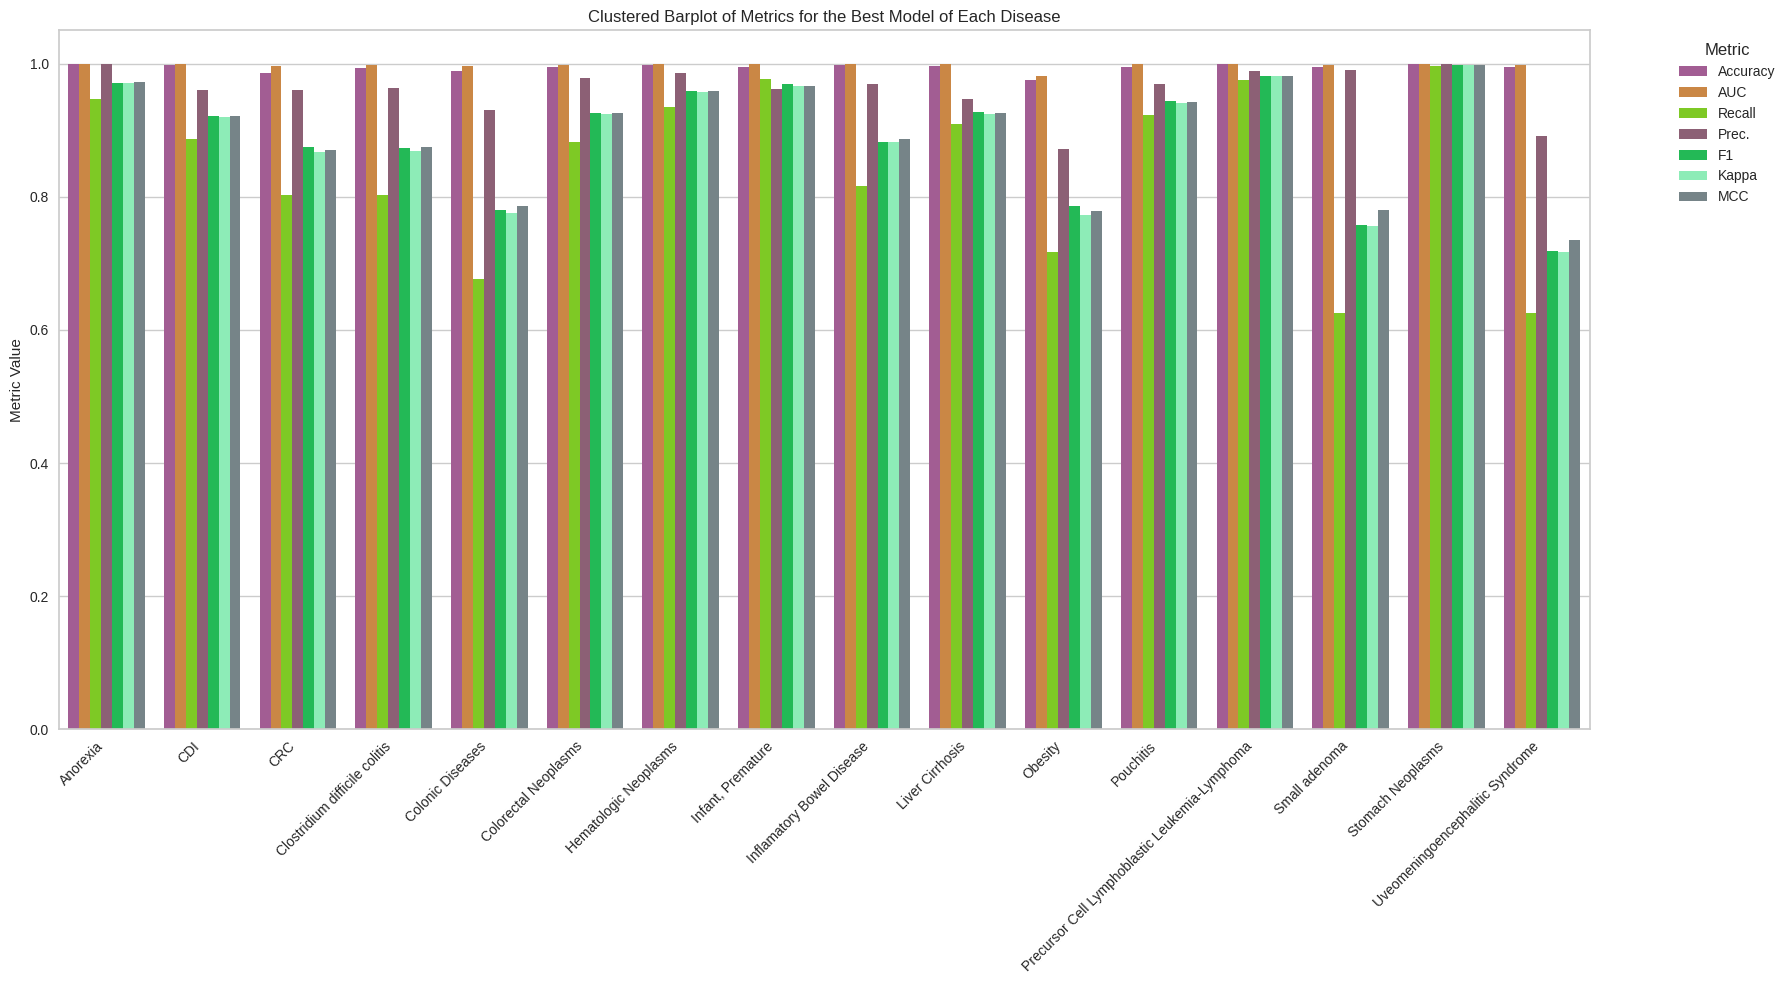

In [94]:
random.seed(69420)

# Get 8 random colors
random_colors = [tuple(random.uniform(0, 1) for _ in range(3)) for _ in range(8)]

# Melt the DataFrame to reshape it for seaborn
melted_df = pd.melt(best_auc_rows, id_vars=['disease'], value_vars=best_auc_rows.columns[1:8], var_name='Metric', value_name='Value')

plt.figure(figsize=(18, 10))
sns.barplot(x='disease', y='Value', hue='Metric', data=melted_df, palette=random_colors)
plt.xlabel('')
plt.ylabel('Metric Value')
plt.title('Clustered Barplot of Metrics for the Best Model of Each Disease')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Metric')
plt.tight_layout()
plt.savefig(f'best_ml_models.png')
plt.show()

# Conclusions